In [1]:
#import statements
%matplotlib inline
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import shutil
import csv
import pandas as pd
import PIL
from sympy import *
#from skimage.color import rgb2gray
from skimage import color
from skimage import morphology
from scipy import stats
from scipy import ndimage
import statistics
import cv2
from skimage import filters
import math
import nibabel as nib
import glob as glob

#print(os.path.isdir(glob.glob(os.path.join("C:\\Temp\\nitish\\3DUnetCNN-master\\3DUnetCNN-Branch-Nitish\\data", "*", "*"))[0]))
#print(glob.glob(os.path.join("C:\\Temp\\nitish\\3DUnetCNN-master\\3DUnetCNN-Branch-Nitish", "data", "preprocessed", "*", "*")))

In [2]:
def roundInt(x):
    x = int(x+0.5)
    if x > 512:
        x = 512
    if x < 0:
        x = 0
    return x

In [3]:
def find_center(x_values, xmin, y_values, ymin):
    """
    x1_index = np.where(x_values == xmin)[0][0]
    p1x = Point(x_values[x1_index], y_values[x1_index])
    x2_index = np.where(x_values == xmax)[0][0]
    p2x = Point(x_values[x2_index], y_values[x2_index])
    
    y1_index = np.where(y_values == ymin)[0][0]
    p1y = Point(x_values[y1_index], y_values[y1_index])
    y2_index = np.where(y_values == ymax)[0][0]
    p2y = Point(x_values[y2_index], y_values[y2_index])
    """
    
    solutions = np.zeros(2)
        
    line1 = Line(Point(x_values[0],y_values[0]), Point(x_values[1],y_values[1]))
    line2 = Line(Point(x_values[2],y_values[2]), Point(x_values[3],y_values[3]))
    line1_coeff = np.asarray(list(line1.coefficients)).astype(np.float)
    line2_coeff = np.asarray(list(line2.coefficients)).astype(np.float)
    solutions = np.array([-1*line1_coeff[2], -1*line2_coeff[2]])
    line1_coeff = np.delete(line1_coeff, 2)
    line2_coeff = np.delete(line2_coeff, 2)
    b = np.array([line1_coeff, line2_coeff])
    row_sol, col_sol = np.linalg.lstsq(b, solutions, rcond = None)[0]
    center = Point(row_sol, col_sol)
        
    return center

In [4]:
df = pd.read_csv("C:\\Temp\\nitish\\Tensorflow\\workspace\\training_demo\\annotations\\train2.csv", usecols=["File_name", "Patient_index", "Study_index", "Series_ID", "Key_slice_index", "Measurement_coordinates", "Bounding_boxes", "Lesion_diameters_Pixel_", "Normalized_lesion_location", "Coarse_lesion_type", "Possibly_noisy", "Slice_range", "Spacing_mm_px_", "Image_size", "DICOM_windows", "Patient_gender", "Patient_age", "Train_Val_Test"])
df.set_index("File_name", inplace = True)

tfrecord_train_filename = "C:\\Temp\\nitish\\Tensorflow\\workspace\\training_demo\\annotations\\train.record"
tfrecord_test_filename = "C:\\Temp\\nitish\\Tensorflow\\workspace\\training_demo\\annotations\\test.record"
test_image_path = "C:\\Temp\\nitish\\Tensorflow\\workspace\\training_demo\\images\\test\\images\\"
train_image_path = "C:\\Temp\\nitish\\Tensorflow\\workspace\\training_demo\\images\\train\\images\\"
test_mask_path = "C:\\Temp\\nitish\\Tensorflow\\workspace\\training_demo\\images\\test\\binary_masks\\"
train_mask_path = "C:\\Temp\\nitish\\Tensorflow\\workspace\\training_demo\\images\\train\\binary_masks\\"
ex_path = "C:\\Temp\\nitish\\Tensorflow\\workspace\\training_demo\\images\\Extracted_Images\\"

os.chdir(train_image_path)
print(os.getcwd())

C:\Temp\nitish\Tensorflow\workspace\training_demo\images\train\images


In [68]:
def get_mask(im, raw_pixels):
    
    if True:
        

        
        #load diameter location
        x_values = raw_pixels[0:7:2]
        y_values = raw_pixels[1:8:2]
        raw_pixels = np.reshape(raw_pixels, (4,2))
        raw_pixels = raw_pixels.astype(np.float)
        xmax = np.amax(x_values)
        xmin = np.amin(x_values)
        ymax = np.amax(y_values)
        ymin = np.amin(y_values)

        
        #generate lines
        
        x1_index = np.where(x_values == xmin)[0][0]
        p1x = Point(x_values[x1_index], y_values[x1_index])
        x2_index = np.where(x_values == xmax)[0][0]
        p2x = Point(x_values[x2_index], y_values[x2_index])

    
    
        y1_index = np.where(y_values == ymin)[0][0]
        p1y = Point(x_values[y1_index], y_values[y1_index])
        y2_index = np.where(y_values == ymax)[0][0]
        p2y = Point(x_values[y2_index], y_values[y2_index])

            
    
        center = find_center(x_values, xmin, y_values, ymin)
        
        
        #extract midpoints
        
        x_min_midpoint = center.midpoint(p1x)
        #x_min_boundary = center.midpoint(x_min_midpoint)
        x_max_midpoint = center.midpoint(p2x)
        #x_max_boundary = center.midpoint(x_max_midpoint)
        y_min_midpoint = center.midpoint(p2y)
        #y_min_boundary = center.midpoint(y_min_midpoint)
        y_max_midpoint = center.midpoint(p1y)
        #y_max_boundary = center.midpoint(y_max_midpoint)

        
    
        #create sampling region
        x_start = roundInt(x_min_midpoint.x)
        x_end = roundInt(x_max_midpoint.x)
        if x_end - x_start < 1:
            x_end = x_end + 1
        y_start = roundInt(y_min_midpoint.y)
        y_end = roundInt(y_max_midpoint.y)
        if y_end - y_start < 1:
            y_start = y_start + 1
        
        im_array = np.array(im)

        im_array = color.rgb2gray(im_array)
    
    
        #calculate median of pixel intensity inside lesion region

        lesionMedian = stats.mstats.hdmedian(im_array[y_end:y_start:1, x_start: x_end:1], axis = None)
        
        #calculate variance of pixel intensities
        if np.ma.is_masked(lesionMedian):
            lesionMedian = im_array[y_end:y_start:1, x_start: x_end:1][0][0]
    
        variance = np.var(im_array[y_end:y_start:1, x_start: x_end:1], axis = None)
        
        
        #construct boundary for cutting lesion mask
        
        bound = 5
        relBound = 0.1
        rbh = roundInt((ymax - ymin)*relBound)+2
        rbw = roundInt((xmax - xmin)*relBound)+2
        height = roundInt(ymax-ymin)
        if height == 0:
            height = 1
            
        width = roundInt(xmax - xmin)
        if width == 0:
            width = 1

        
        
        #relatively constructed lesion boxes
        
        
        relativeLesionBox = im_array[(roundInt(ymin)-rbh):(roundInt(ymax)+rbh):1, (roundInt(xmin)-rbw):(roundInt(xmax)+rbw):1]
        smallLesionBox = im_array[roundInt(ymin):(roundInt(ymin + height)):1, roundInt(xmin):(roundInt(xmin + width)):1]
        lesionBox = im_array[roundInt(ymin-bound):roundInt(ymax+bound):1, roundInt(xmin-bound):roundInt(xmax+bound):1]
        
        #plt.imshow(lesionBox, cmap='gray')
        
        
        #determine bimodality
        
        if variance > 5000 and not((smallLesionBox == smallLesionBox[0][0]).all()):
            split = filters.threshold_otsu(smallLesionBox)
            lowDS = np.extract(smallLesionBox < split, smallLesionBox)
            highDS = np.extract(smallLesionBox > split, smallLesionBox)

            val = np.var(lowDS) + np.var(highDS)
            
            
            #if bimodal, recalculate variance and median 
            
            if val  < 55000:

                lowCount = np.count_nonzero(smallLesionBox < split)
                highCount = np.count_nonzero(smallLesionBox > split)
                if lowCount > highCount:
                    variance = np.var(lowDS)
                    lesionMedian = stats.mstats.hdmedian(lowDS, axis = None)
                else:
                    variance = np.var(highDS)
                    lesionMedian = stats.mstats.hdmedian(highDS, axis = None)
        
      
        
        #Find minimum difference in intensity from top, bottom, left, and right
    
        r, c = relativeLesionBox.shape
        
        mol= np.median(relativeLesionBox[:, :rbw:1])
        difference1 = abs(lesionMedian - mol)
        
        
        length1 = roundInt((xmax - xmin)+rbw)
        if length1 > c:
            length1 = c
        
        mor= np.median(relativeLesionBox[:, length1::1])
        difference2 = abs(lesionMedian - mor)
   
        mot= np.median(relativeLesionBox[:rbh:1, :]) 
        difference3 = abs(lesionMedian - mot)
        
        length2 = roundInt((ymax-ymin)+rbh)
        if length2 > r:
            length2 = r
        
        mob= np.median(relativeLesionBox[length2::1, :])
        difference4 = abs(lesionMedian - mob)
        
        differences = np.array([difference1,difference2,difference3,difference4])
        
        avg_mode_diff = np.nanmin(differences)

            
        h, w = smallLesionBox.shape
        isLarge = h > 70 or w > 70

        
        #adjusting outlying differences and variances
        
        if avg_mode_diff > 250:
            avg_mode_diff = 22.5*sqrt(avg_mode_diff - 127)

        if variance > 1500:

            variance = (variance - 1500)**0.68 + 1500

    
        diff = np.empty([roundInt(2*bound+ymax-ymin), roundInt(2*bound+xmax-xmin)])
         
            
        #creating slack for clipping    
        xSlack = roundInt(0.06*(xmax - xmin + 2*bound))
        ySlack = roundInt(0.06*(ymax - ymin + 2*bound))
        finalx = bound-xSlack
        if finalx < 0:
            finalx = 0
        finaly = bound-ySlack
        if finaly < 0:
            finaly = 0
        
        
        #if lesion is large, slack is different, and variance is adjusted
        if isLarge:
            xSlack = 3
            ySlack = 3
            finaly = bound-3
            finalx = bound-3
            variance = variance/2.5
        

        #FINAL THRESHOLD EQUATION
        threshold = 0.4*avg_mode_diff + 0.25*(variance**0.76) + 10
        
        #threshold adjustments for outlying values
        if variance > 1500 and avg_mode_diff < 65:
            threshold = threshold ** 0.85

        if avg_mode_diff < 5 and variance > 100:
            threshold += 5
        if avg_mode_diff < 20 and variance < 200:
            threshold -= 5
        if threshold > 600:
            threshold = ((threshold - 600)**0.95) + 600
        if threshold < 0: 
            threshold = 5
            
        #construct mask from threshold    
        diff = abs(lesionBox - lesionMedian) < threshold
        
        diff[:, (roundInt((xmax - xmin) + bound) + xSlack):] = False #if this no work, then add some variable number(20% slack??)
        diff[:, :finalx] = False
        diff[:finaly, :] = False
        diff[(roundInt((ymax-ymin) + bound) + ySlack):, :] = False

        
        #apply morphological operations
        
        area = 0.3*((ymax - ymin)*(xmax - xmin))
        diff = morphology.remove_small_objects(diff,  min_size=area).astype(int)
        diff = ndimage.binary_fill_holes(diff).astype(int)
        if area > 0:
            diff = ndimage.binary_opening(diff).astype(int)
        diff = ndimage.binary_closing(diff).astype(int)
        
        
        
        #iteratively increase threshold for masks that are blank
        
        varianceFactor = 40
        
        if variance > 3000:
            varianceFactor = 140
            
        if (np.count_nonzero(diff)/(h*w)) < 0.3:

            for n in range(0,50):
                threshold += 15
                
                diff = abs(lesionBox - lesionMedian) < threshold
                
                diff[:, (roundInt((xmax - xmin) + bound)):] = False #if this no work, then add some variable number(20% slack??)
                diff[:, :bound] = False
                diff[:bound, :] = False
                diff[(roundInt((ymax-ymin) + bound)):, :] = False

                area = 0.3*((ymax - ymin)*(xmax - xmin))
                diff = morphology.remove_small_objects(diff,  min_size=area).astype(int)

                diff = ndimage.binary_erosion(diff).astype(int)
                
                if diff.any():
                    threshold += varianceFactor
                    diff = abs(lesionBox - lesionMedian) < threshold
                
                    diff[:, (roundInt((xmax - xmin) + bound) + xSlack):] = False #if this no work, then add some variable number(20% slack??)
                    diff[:, :finalx] = False
                    diff[:finaly, :] = False
                    diff[(roundInt((ymax-ymin) + bound) + ySlack):, :] = False
                    
                    diff = ndimage.binary_fill_holes(diff).astype(int)
                    diff = ndimage.binary_closing(diff).astype(int)
                    diff = ndimage.binary_opening(diff).astype(int)
                    break

        """
        #plotting
        
        x_values[0] -= (xmin - bound)
        x_values[1] -= (xmin - bound)
        y_values[0] -= (ymin - bound)
        y_values[1] -= (ymin - bound)
        plt.plot(x_values[0:2], y_values[0:2])
        
        x_values[2] -= (xmin - bound)
        x_values[3] -= (xmin - bound)
        y_values[2] -= (ymin - bound)
        y_values[3] -= (ymin - bound)
        plt.plot(x_values[2:4], y_values[2:4])
        
        centerx = center.x - (xmin - bound)
        centery = center.y - (ymin - bound)
        plt.plot(centerx, centery, 'ro')
           
        plt.figure()    
            
        plt.imshow(diff, cmap='gray')
        plt.figure()
        """
            
        #apply final operations and paste onto an image for training.
        diff = morphology.remove_small_objects(diff,  min_size=area).astype(int)
        diff = ndimage.binary_fill_holes(diff).astype(int)
        
        diff[:, (roundInt((xmax - xmin) + bound) + xSlack):] = False #if this no work, then add some variable number(20% slack??)
        diff[:, :finalx] = False
        diff[:finaly, :] = False
        diff[(roundInt((ymax-ymin) + bound) + ySlack):, :] = False
        
        diffImage = PIL.Image.fromarray(diff)
        diffImage = diffImage.convert('L')
        mask = PIL.Image.new('L', (512,512))
        mask.paste(diffImage, (roundInt(xmin-bound), roundInt(ymin-bound), roundInt(xmax+bound), roundInt(ymax+bound)))
        
        mask_array = np.array(mask)
        return mask_array

In [69]:
def get_lesion_box(im, img_name):
    
    if df.loc[img_name]["Possibly_noisy"] == 0:
        

        
        #load diameter location
        raw_pixels = np.asarray(df.loc[img_name]["Measurement_coordinates"].split(","))
        x_values = raw_pixels[0:7:2].astype(np.float)
        y_values = raw_pixels[1:8:2].astype(np.float)
        raw_pixels = np.reshape(raw_pixels, (4,2))
        raw_pixels = raw_pixels.astype(np.float)
        xmax = np.amax(x_values)
        xmin = np.amin(x_values)
        ymax = np.amax(y_values)
        ymin = np.amin(y_values)
        
        im_array = np.array(im)

        im_array = color.rgb2gray(im_array)
        
        
        #construct boundary for cutting lesion mask
        
        bound = 5

        
        
        #relatively constructed lesion boxes
        
        lesionBox = im_array[roundInt(ymin-bound):roundInt(ymax+bound):1, roundInt(xmin-bound):roundInt(xmax+bound):1]
        
        return lesionBox
        

In [70]:
def get_threshold(im, raw_pixels):
    

        
        #load diameter location
        x_values = np.array(raw_pixels[0:7:2]).astype(np.float)
        y_values = np.array(raw_pixels[1:8:2]).astype(np.float)
        raw_pixels = np.reshape(raw_pixels, (4,2))
        raw_pixels = raw_pixels.astype(np.float)
        xmax = np.amax(x_values)
        xmin = np.amin(x_values)
        ymax = np.amax(y_values)
        ymin = np.amin(y_values)

        
        #generate lines
        
        x1_index = np.where(x_values == xmin)[0][0]
        p1x = Point(x_values[x1_index], y_values[x1_index])
        x2_index = np.where(x_values == xmax)[0][0]
        p2x = Point(x_values[x2_index], y_values[x2_index])

    
    
        y1_index = np.where(y_values == ymin)[0][0]
        p1y = Point(x_values[y1_index], y_values[y1_index])
        y2_index = np.where(y_values == ymax)[0][0]
        p2y = Point(x_values[y2_index], y_values[y2_index])
        

            
    
        center = find_center(x_values, xmin, y_values, ymin)
        
        
        #extract midpoints
        """
        x_min_midpoint = center.midpoint(p1x)
        #x_min_boundary = center.midpoint(x_min_midpoint)
        x_max_midpoint = center.midpoint(p2x)
        #x_max_boundary = center.midpoint(x_max_midpoint)
        y_min_midpoint = center.midpoint(p2y)
        #y_min_boundary = center.midpoint(y_min_midpoint)
        y_max_midpoint = center.midpoint(p1y)
        #y_max_boundary = center.midpoint(y_max_midpoint)
        """
        
    
        #create sampling region
        x_start = roundInt(xmin)
        x_end = roundInt(xmax)
        if x_end - x_start <= 2:
            x_end = x_end + 1
            #SAMPLING REGION BECOMES TOO SMALL
            return -1
        y_start = roundInt(ymin)
        y_end = roundInt(ymax)
        if y_end - y_start <= 2:
            y_start = y_start + 1
            return -1

        im_array = np.array(im)
        im_array = color.rgb2gray(im_array)
        #print(im_array.shape)
    
        #calculate median of pixel intensity inside lesion region
        #print(y_end, y_start, x_end, x_start)
        
        
        lesionMedian = stats.mstats.hdmedian(im_array[y_start:y_end:1, x_start: x_end:1], axis = None)
        
        lesionMean = np.mean(im_array[y_start:y_end:1, x_start: x_end:1], axis = None)
        #print("median:" + str(lesionMedian))
        #print(im_array[y_end:y_start:1, x_start: x_end:1])
        #calculate variance of pixel intensities
        if np.ma.is_masked(lesionMedian):
            lesionMedian = (im_array[y_start:y_end:1, x_start: x_end:1])[0][0]
    
        
        variance = np.var(im_array[y_start:y_end:1, x_start: x_end:1], axis = None)
        
        
        #construct boundary for cutting lesion mask
        
        bound = 5
        relBound = 0.1
        rbh = roundInt((ymax - ymin)*relBound)+2
        rbw = roundInt((xmax - xmin)*relBound)+2
        height = roundInt(ymax-ymin)
        if height == 0:
            height = 1
            
        width = roundInt(xmax - xmin)
        if width == 0:
            width = 1

        
        
        #relatively constructed lesion boxes
        
        
        relativeLesionBox = im_array[(roundInt(ymin)-rbh):(roundInt(ymax)+rbh):1, (roundInt(xmin)-rbw):(roundInt(xmax)+rbw):1]
        smallLesionBox = im_array[roundInt(ymin):(roundInt(ymin + height)):1, roundInt(xmin):(roundInt(xmin + width)):1]
        #lesionBox = im_array[roundInt(ymin-bound):roundInt(ymax+bound):1, roundInt(xmin-bound):roundInt(xmax+bound):1]
        
        
        #plt.imshow(lesionBox, cmap='gray')
        
        
        #determine bimodality
        
        if variance > 5000 and not((smallLesionBox == smallLesionBox[0][0]).all()):
            split = filters.threshold_otsu(smallLesionBox)
            lowDS = np.extract(smallLesionBox < split, smallLesionBox)
            highDS = np.extract(smallLesionBox > split, smallLesionBox)

            val = np.var(lowDS) + np.var(highDS)
            
            
            #if bimodal, recalculate variance and median 
            
            if val  < 55000:

                lowCount = np.count_nonzero(smallLesionBox < split)
                highCount = np.count_nonzero(smallLesionBox > split)
                if lowCount > highCount:
                    variance = np.var(lowDS)
                    lesionMedian = stats.mstats.hdmedian(lowDS, axis = None)
                else:
                    variance = np.var(highDS)
                    lesionMedian = stats.mstats.hdmedian(highDS, axis = None)
        
      
        
        #Find minimum difference in intensity from top, bottom, left, and right
        
        r, c = relativeLesionBox.shape
        
        mol= np.median(relativeLesionBox[:, :rbw:1])
        difference1 = abs(lesionMedian - mol)
        
        
        length1 = roundInt((xmax - xmin)+rbw)
        if length1 > c:
            length1 = c
        
        mor= np.median(relativeLesionBox[:, length1::1])
        difference2 = abs(lesionMedian - mor)
   
        mot= np.median(relativeLesionBox[:rbh:1, :]) 
        difference3 = abs(lesionMedian - mot)
        
        length2 = roundInt((ymax-ymin)+rbh)
        if length2 > r:
            length2 = r
        
        mob= np.median(relativeLesionBox[length2::1, :])
        difference4 = abs(lesionMedian - mob)
        
        differences = np.array([difference1,difference2,difference3,difference4])
        
        avg_mode_diff = np.nanmin(differences)

        
        h, w = smallLesionBox.shape
        isLarge = h > 70 or w > 70

        
        #adjusting outlying differences and variances
        
        #if avg_mode_diff > 250:
        #   avg_mode_diff = 22.5*sqrt(avg_mode_diff - 127)

        if variance > 1500:

            variance = (variance - 1500)**0.68 + 1500

         
            
        #creating slack for clipping    
        """
        xSlack = roundInt(0.06*(xmax - xmin + 2*bound))
        ySlack = roundInt(0.06*(ymax - ymin + 2*bound))
        finalx = bound-xSlack
        if finalx < 0:
            finalx = 0
        finaly = bound-ySlack
        if finaly < 0:
            finaly = 0
        """
        
        
        #if lesion is large, slack is different, and variance is adjusted
        if isLarge:
            #xSlack = 3
            #ySlack = 3
            #finaly = bound-3
            #finalx = bound-3
            variance = variance/2.5
        

        #FINAL THRESHOLD EQUATION
        #0.4*avg_mode_diff + 0.25*(variance**0.76)
        threshold = (lesionMean)
        
        #print("threshold: " + str(threshold))
        return threshold, avg_mode_diff, variance

In [71]:
def shrink_diameters(rate, inputxy, center):
    
    x_values = np.array(inputxy[0:7:2]).astype(np.float)
    y_values = np.array(inputxy[1:8:2]).astype(np.float)
    
    p1x = Point(x_values[0], y_values[0])
    p2x = Point(x_values[1], y_values[1])
    p1y = Point(x_values[2], y_values[2])
    p2y = Point(x_values[3], y_values[3])

    #xmin shifts
    x1shift1 = rate*(p1x.x - center.x)
    y1shift1 = rate*(p1x.y - center.y)
    #xmax shists
    x2shift1 = rate*(p2x.x - center.x)
    y2shift1 = rate*(p2x.y - center.y)
    #ymin shifts
    y1shift2 = rate*(p1y.y - center.y)
    x1shift2 = rate*(p1y.x - center.x)
    #ymax shifts
    y2shift2 = rate*(p2y.y - center.y)
    x2shift2 = rate*(p2y.x - center.x)

    x_values[0] = p1x.x - x1shift1
    y_values[0] = p1x.y - y1shift1
    x_values[1] = p2x.x - x2shift1
    y_values[1] = p2x.y - y2shift1
    
    y_values[2] = p1y.y - y1shift2
    x_values[2] = p1y.x - x1shift2
    y_values[3] = p2y.y - y2shift2
    x_values[3] = p2y.x - x2shift2
    
    raw_pixels = [x_values[0], y_values[0], x_values[1], y_values[1], x_values[2], y_values[2], x_values[3], y_values[3]]
        
    return raw_pixels

In [72]:
def plotted_image(im, inputxy, image_name, center):
    plt.figure()
    
    
    raw_pixels = np.asarray(df.loc[image_name]["Measurement_coordinates"].split(","))
    x_values = raw_pixels[0:7:2].astype(np.float)
    y_values = raw_pixels[1:8:2].astype(np.float)

    xmax1 = np.amax(x_values)
    xmin1 = np.amin(x_values)
    ymax1= np.amax(y_values)
    ymin1 = np.amin(y_values)
    
    lesionBox = get_lesion_box(im, image_name)
    
    plt.imshow(lesionBox, cmap = 'gray')
    
    x_values = np.array(inputxy[0:7:2]).astype(np.float)
    y_values = np.array(inputxy[1:8:2]).astype(np.float)
    
    xmax = np.amax(x_values)
    xmin = np.amin(x_values)
    ymax = np.amax(y_values)
    ymin = np.amin(y_values)
    
    
    bound = 5
    
    #center = find_center(x_values, xmin, y_values, ymin)
    
    x_values[0] -= (xmin1 - bound)
    x_values[1] -= (xmin1 - bound)
    y_values[0] -= (ymin1 - bound)
    y_values[1] -= (ymin1 - bound)
    #plt.plot(x_values[0:2], y_values[0:2])
        
    x_values[2] -= (xmin1 - bound)
    x_values[3] -= (xmin1 - bound)
    y_values[2] -= (ymin1 - bound)
    y_values[3] -= (ymin1 - bound)
    #plt.plot(x_values[2:4], y_values[2:4])
        
    centerx = center.x - (xmin - bound)
    centery = center.y - (ymin - bound)
    #plt.plot(centerx, centery, 'ro')
    
    plt.figure()
    return None

In [73]:
def find_border(raw_pixels, im, curr_threshold, center, min_diff, size):
    #print("original threshold" + str(curr_threshold))
    threshold_diff = 25
    threshold_diff = (0.0369*size)+13.5

    if curr_threshold is not -1:
        for i in range (1,6):
            #shrink = i * 0.1
            shrink = 0.1
            
            raw_pixels = shrink_diameters(shrink, raw_pixels, center)
            #print(raw_pixels)
            #print(raw_pixels)
            thresh, temp, temp2 = get_threshold(im, raw_pixels)
            if thresh is not -1:
                if(abs(curr_threshold - thresh) < threshold_diff):
                    #print("BOUNDARY FOUND!")
                    #plotted_image(im_prev, raw_pixels, image, center)
                    return get_mask(im, raw_pixels), thresh, raw_pixels
    #print("BLANK MASK GENERATED!")
    #plotted_image(im_prev, raw_pixels, image, center)
    return np.zeros((512, 512)), -1, raw_pixels

In [74]:
def slices2nifti(ims, mask, spacing_in, img_name):
    """save 2D slices to 3D nifti file considering the spacing"""
    #if len(ims) < 300:  # cv2.merge does not support too many channels
        #V = cv2.merge(ims)
    #else:
    a, b = img_name.split(".")
    image_path = str(("C:\\Temp\\nitish\\3DUnetCNN-master\\3DUnetCNN-Branch-Nitish\\data\\preprocessed\\subjects\\" + str(a)) + "\\" + a + "_main.nii.gz")
    mask_path = str(("C:\\Temp\\nitish\\3DUnetCNN-master\\3DUnetCNN-Branch-Nitish\\data\\preprocessed\\subjects\\" + str(a)) + "\\" + a + "_truth.nii.gz")
    ims = [((im.astype(np.int32) - 32768).astype(np.int16)) for im in ims]
 
    V = np.empty((ims[0].shape[0], ims[0].shape[1], len(ims)))
    for i in range(len(ims)):
        V[:, :, i] = ims[i]
    Vm = np.empty((ims[0].shape[0], ims[0].shape[1], len(ims)))
    for i in range(len(mask)):
        Vm[:, :, i] =mask[i]

    # the transformation matrix suitable for 3D slicer and ITK-SNAP
    T = np.array([[0, -spacing_in[1], 0, 0], [-spacing_in[0], 0, 0, 0], [0, 0, -spacing_in[2], 0], [0, 0, 0, 1]])
    img = nib.Nifti1Image(V, T)
    mask = nib.Nifti1Image(Vm, T)
    nib.save(img, image_path)
    nib.save(mask, mask_path)
    print(a, 'saved')


c:\program files\python\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  


FIND PREVIOUS MASK 0
FIND NEXT MASK 0
FIND PREVIOUS MASK 1
FIND NEXT MASK 1
FIND PREVIOUS MASK 2
FIND NEXT MASK 2
7


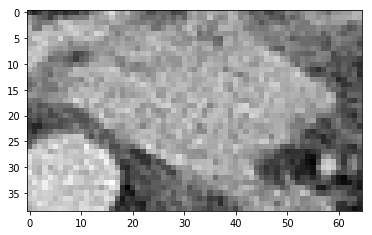

<Figure size 432x288 with 0 Axes>

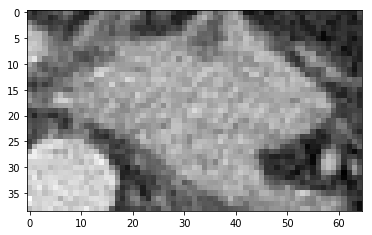

<Figure size 432x288 with 0 Axes>

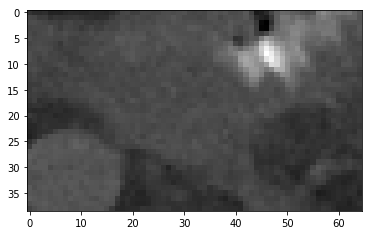

<Figure size 432x288 with 0 Axes>

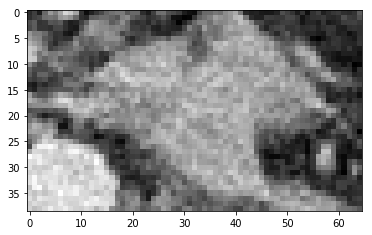

<Figure size 432x288 with 0 Axes>

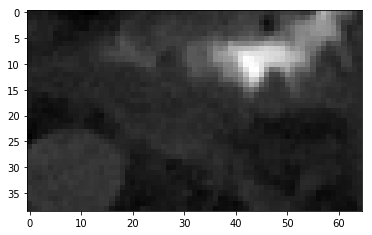

<Figure size 432x288 with 0 Axes>

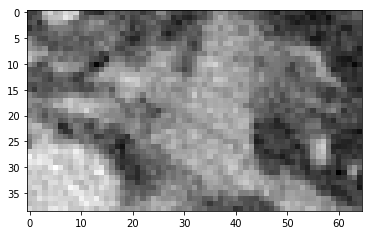

<Figure size 432x288 with 0 Axes>

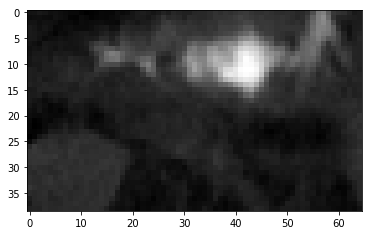

<Figure size 432x288 with 0 Axes>

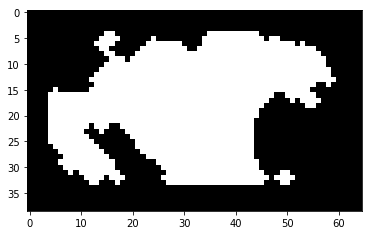

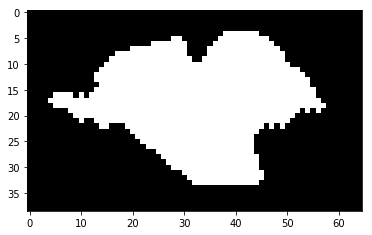

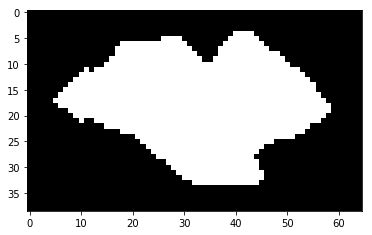

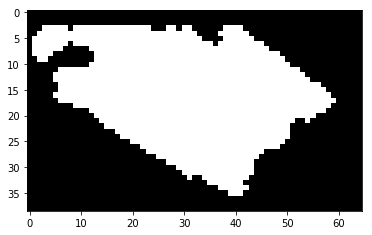

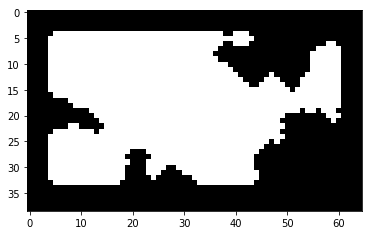

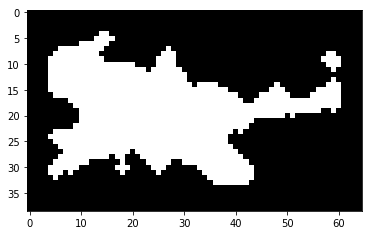

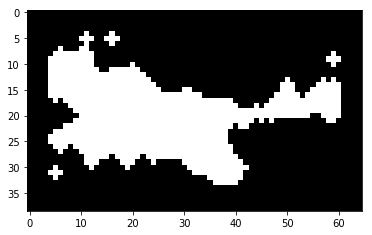

<Figure size 432x288 with 0 Axes>

In [75]:
count = 0
dupList = df.index.get_duplicates()

#iterate through pictures
for image in os.listdir():
    
    err = 0
    count+=1
    
    
    if count < 7:
            continue
    #image.shape[0] == 512 and
    if not(image in dupList):
        
            
        
        
        x,y = image.split(".")
        image_name = str(train_image_path + x + "." + y)
        img = np.array(PIL.Image.open(image_name))
        
    
        #load images and masks
    
        if df.loc[image]["Possibly_noisy"] == 0:
        
            string_pixels = str(df.loc[image]["Measurement_coordinates"])
            raw_pixels = np.asarray(string_pixels.split(','))
        
            
            x_values = np.array(raw_pixels[0:7:2]).astype(np.float)
            y_values = np.array(raw_pixels[1:8:2]).astype(np.float)
    
            xmax = np.amax(x_values)
            xmin = np.amin(x_values)
            ymax = np.amax(y_values)
            ymin = np.amin(y_values)
            
            
            
            center = find_center(x_values, xmin, y_values, ymin)
            
            #print("runh")
            #check image viability
            if xmin > 512 or xmax > 512 or ymin > 512 or ymax > 512:
                continue
            
            
            spacing = str(df.loc[image]["Spacing_mm_px_"])
            slice_prop = np.asarray(spacing.split(','))[2].astype(np.float)
        
            
            idx = int(df.loc[image]["Key_slice_index"])
            ranger = str(df.loc[image]["Slice_range"])
            minslice, maxslice = ranger.split(',')
            minslice = int(minslice)
            maxslice = int(maxslice)
            
            
            a,b,m,d = x.split("_")
            target_dir = a + "_" + b + "_" + m
            #To generate 3D images, image propagation was implemented to look spatially above and below each key slice. 
            diameters = df.loc[image]["Lesion_diameters_Pixel_"]
            area = np.asarray(diameters.split(','))[0].astype(np.float) * np.asarray(diameters.split(','))[1].astype(np.float)
            
            
            
            #break
            width  = sqrt(area)
            #interval = round(width/6.55, 2)
            interval = 0.14*width + 1.12
        
            mask_name = str(train_mask_path + x + "_mask" + "." + y)
            mask = np.array(PIL.Image.open(mask_name))
            #break
            size, nums = np.unique(mask, return_counts = True)
            """
            try:
                print("size: " + str(nums[1]))
            except:
                continue 
            """
            mask = [mask]
            ims = [img]
            number_props = 3
            # find neighboring slices of im_cur
            rel_pos = float(interval)/slice_prop
            a = rel_pos - np.floor(rel_pos)
            b = np.ceil(rel_pos) - rel_pos
            plotted_image(img, raw_pixels, image, center=center)
            
            #init_threshold_prev, min_diff, var = get_threshold(img, raw_pixels)
            try:
                init_threshold_prev, min_diff, var = get_threshold(img, raw_pixels)
            except:
                continue

            init_threshold_next = init_threshold_prev
            
            #print("runh")
            
            
            if a == 0:  # required SLICE_INTV is a divisible to the actual slice_intv, don't need interpolation
            
                       
                for p in range(number_props):
                    
                    #print("runh")
                    
                    #raw_pixels = shrink_diameters(0.2, raw_pixels)
                    prev_index = idx - (rel_pos * (p+1))
                    if prev_index < minslice:
                        prev_index = minslice
                    prev_index = int(prev_index)
                    im_prev =  np.array(PIL.Image.open(str(ex_path + target_dir + "\\" + str(f'{prev_index:03}' + ".png"))))
                    
                    
                    
                    print("FIND PREVIOUS MASK " + str(p))
                    im_prev_mask, init_threshold_prev, prev_raw_pixels = find_border(prev_raw_pixels, im_prev, init_threshold_prev, center, min_diff, nums[1])
            
            
            
            
            
                    next_index = idx + (rel_pos * (p+1))
                    if next_index > maxslice:
                        next_index = maxslice
                    next_index = int(next_index)
                    im_next =  np.array(PIL.Image.open(str(ex_path + target_dir + "\\" + str(f'{next_index:03}' + ".png"))))
                    
                    
                    
                    print("FIND NEXT MASK " + str(p))
                    im_next_mask, init_threshold_next, next_raw_pixels = find_border(next_raw_pixels, im_next, init_threshold_next, center, min_diff, nums[1])
                
                    
                
                
                    ims = [im_prev] + ims + [im_next]    
                    mask = [im_prev_mask] + mask + [im_next_mask]
                
                
            else:
            
                for p in range(number_props):
                    
                    
                    #print("runh")
                    
                    intv1 = rel_pos*(p+1)
                    #print(raw_pixels)
                    prev_raw_pixels = raw_pixels
                    next_raw_pixels = raw_pixels
                    
                    prev_index_1 = idx - np.ceil(intv1)
                    if prev_index_1 < minslice:
                        prev_index_1 = minslice
                    prev_index_1 = int(prev_index_1)
                
                    prev_index_2 = idx - np.floor(intv1)
                    if prev_index_2 < minslice:
                        prev_index_2 = minslice
                    prev_index_2 = int(prev_index_2)
                
                    slice1 = np.array(PIL.Image.open(str(ex_path + target_dir + "\\" + str(f'{prev_index_1:03}' + ".png"))))
                    slice2 = np.array(PIL.Image.open(str(ex_path + target_dir + "\\" + str(f'{prev_index_2:03}' + ".png"))))
                    im_prev = a * slice1 + b * slice2  # linear interpolation
                    
                    
                    
                    print("FIND PREVIOUS MASK " + str(p))
                    try:
                        im_prev_mask, init_threshold_prev, prev_raw_pixels = find_border(prev_raw_pixels, im_prev, init_threshold_prev, center, min_diff, nums[1])
                    except:
                        
                        err +=1
                        break
                
                
                    plotted_image(im_prev, prev_raw_pixels, image, center=center)
                    #plt.figure()
                    #plt.imshow(get_mask(im_prev, prev_raw_pixels))
                
                    #print(count)
                    next_index_1 = idx + np.ceil(intv1)
                    if next_index_1 > maxslice:
                        next_index_1 = maxslice
                    next_index_1 = int(next_index_1)
                
                    next_index_2 = idx + np.floor(intv1)
                    if next_index_2 > maxslice:
                        next_index_2 = maxslice
                    next_index_2 = int(next_index_2)
                
                    slice1 = np.array(PIL.Image.open(str(ex_path + target_dir + "\\" + str(f'{next_index_1:03}' + ".png"))))
                    slice2 = np.array(PIL.Image.open(str(ex_path + target_dir + "\\" + str(f'{next_index_2:03}' + ".png"))))
                    im_next = a * slice1 + b * slice2  # linear interpolation
                    
                    
                    
                    print("FIND NEXT MASK " + str(p))
                    try:
                        im_next_mask, init_threshold_next, next_raw_pixels = find_border(next_raw_pixels, im_next, init_threshold_next, center, min_diff, nums[1])
                    except:
                        
                        err+=1
                        break
                
                    plotted_image(im_next, next_raw_pixels, image, center=center)
                    #plt.figure()
                    #plt.imshow(get_mask(im_prev, next_raw_pixels))
                    
                    
                    ims = [im_prev] + ims + [im_next]
                    mask = [im_prev_mask] + mask + [im_next_mask]
                
            #break
            if err == 1:
                continue
                
            ims = [im.astype(float) for im in ims]
            
            
            mask = [ma.astype(int) for ma in mask]
            #break
            
            mask1 = mask[0]
            mask2 = mask[1]
            mask3 = mask[2]
            mask4 = mask[3]
            mask5 = mask[4]
            mask6 = mask[5]
            mask7 = mask[6]
            
            
            plt.figure()
            plt.imshow(get_lesion_box(mask1, image), cmap='gray')
            plt.figure()
            plt.imshow(get_lesion_box(mask2, image), cmap='gray')
            plt.figure()
            plt.imshow(get_lesion_box(mask3, image), cmap='gray')
            plt.figure()
            plt.imshow(get_lesion_box(mask4, image), cmap='gray')
            plt.figure()
            plt.imshow(get_lesion_box(mask5, image), cmap='gray')
            plt.figure()
            plt.imshow(get_lesion_box(mask6, image), cmap='gray')
            plt.figure()
            plt.imshow(get_lesion_box(mask7, image), cmap='gray')
            plt.figure()
            
            break
            
            try:
                mask3d = cv2.merge(mask)
                im = cv2.merge(ims)
            except:
                continue
            
            #slice_prop_x = np.asarray(spacing.split(','))[0].astype(np.float)
            #slice_prop_y = np.asarray(spacing.split(','))[1].astype(np.float)
            #spaces = [slice_prop_x, slice_prop_y, interval]
            #print(spaces)
            
            #os.mkdir("C:\\Temp\\nitish\\3DUnetCNN-master\\3DUnetCNN-Branch-Nitish\\data\\preprocessed\\subjects\\" + str(x))
            #slices2nifti(im, mask3d, spaces, image)
            
            
            if count == 7:
                break


print(count)
